# Import delle librerie necessarie

In [78]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [79]:
pip install yfinance, skorch

ERROR: Invalid requirement: 'yfinance,'


In [80]:
!git clone https://github.com/AntonioDelleCanne/tesi.git

Cloning into 'tesi'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 113 (delta 42), reused 94 (delta 26), pack-reused 0
Receiving objects: 100% (113/113), 8.25 MiB | 6.04 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [81]:
%cd tesi/DeepLearning_Financial

/content/tesi/DeepLearning_Financial/tesi/DeepLearning_Financial/tesi/DeepLearning_Financial/tesi/DeepLearning_Financial


In [82]:
## EXTERNAL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import yfinance
from pandas import Series
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from IPython.display import display
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import time
import os
import random 
from sklearn.datasets import make_regression
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from torch.nn.modules.loss import MSELos

##INTERNAL
from models import Autoencoder
from models import Sequence
from models import waveletSmooth
from utils import prepare_data_lstm, ExampleDataset, save_checkpoint, evaluate_lstm, backtest

ModuleNotFoundError: ignored

# Raccolta dati e analisi esplorativa

Carichiamo i dati da YahooFinance utilizzando l'API yfinance.
Questa fornisce dati storici su un'ampia gamma di stock, e permette di ottenerli in dataframe Pandas.

Da questa API otteniamo le seguenti informazioni indicizzare per data(YYYY-MM-DD):

 - `Open`: valore della security al momento dell'apertua del mercato
 
 - `Close`: valore della security al momento della chiusura del mercato
 
 - `Low`: valore minimo che la security ha raggiunto durante la gionrata
 
 - `High`: valore massimo che la security ha raggiunto durante la gionrata 
 
 - `Volume`: numero di transazioni eseguite sulle security dello stock al momento della chiusura del mercato. Nella scelta dello stock, ne volgiamo considerare uno che abbia un volume abbastanza alto, in modod da facilitare le transazioni.

In [ ]:
start_date = "2000-01-01"
end_date = "2017-12-31"
security = yfinance.Ticker("DJIA")
security_data = security.history(start=start_date, end=end_date, actions=False)

In [ ]:
security_data.describe()

,Open,High,Low,Close,Volume
count,4528.000000,4528.000000,4528.000000,4528.000000,4.528000e+03
mean,12740.565071,12860.832849,12620.891407,12743.508149,3.037059e+09
std,3608.789477,3610.574730,3609.466386,3610.827892,1.533750e+09
min,6547.010000,6758.440000,6440.080000,6547.050000,2.200000e+06
25%,10314.365000,10416.732500,10211.222500,10314.695000,1.556750e+09
50%,11362.830000,11471.115000,11241.835000,11364.775000,3.117765e+09
75%,15106.982500,15203.210000,15002.562500,15113.035000,3.938362e+09
max,24849.630000,24973.150000,24729.000000,24837.510000,1.145623e+10


In [ ]:
#per essereconsiderata nella nostra analisi, una feature deve essere disponibile all'inizio della giornata, se cosi' non e',
#possiamo considerarne i valori delle gionrate passate usando il metodo shift dei dataframe e delle serie pandas

open = security_data["Open"] #disponibile all'apertura
high = security_data["High"] #non disponibile all'apertura
low = security_data["Low"] #non disponibile all'apertura
close = security_data["Close"] #non disponibile all'apertura
volume = security_data["Volume"] #non disponibile all'apertura

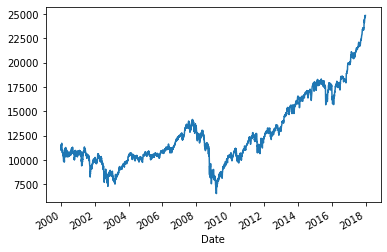

In [ ]:
open.plot()

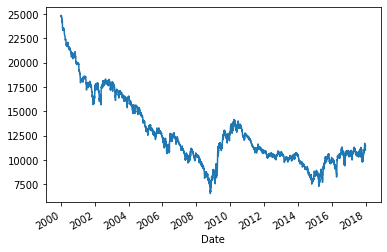

In [ ]:
open_inv = pd.Series(open.values, index=open.index[::-1])
open_inv.plot()

# Allenamento modello

## Metriche
Come metrica principale per valutare la bonta' dele predizioni utilizzeremo il Return of Investment (ROI).

Con questa metrica assumiamo di utilizzare l'algoritmo di trading precedentemente descritto, e calcoliamo il guadango che avremmo ottenuto se lo avessimo utilizzato sul dataset che stiamo valutando.

In [ ]:
def gain(C, C_pred):
    O = open.reindex_like(C)
    CO_diff = C - O
    growth = C_pred > O
    decline = C_pred < O
    return CO_diff[growth].sum() - CO_diff[decline].sum()
def roi(C, C_pred):
    mean_open = open.reindex_like(C).mean()
    return gain(C, C_pred) / mean_open

## Preparazione dei dati
Come spiegato in precedenza, visto che alcune feature non sono disponibili all'inizio della giornata, per poterle utilizzare nel nostro modello, utilizzeremo i dati dei giori passati, servendoci della funzione shift.

Visto che l'utilizzo di questa funzione fara' si che in alcune riche vi saranno dei vaolri NaN, dobbiamo assicurarci di eliminare queste osservazioni sia nelle serie relative ale features che in quella della variabile da predire.
Questo compito e' svolto dalla funzione prepare_data.

In [ ]:
def prepare_data(features, target):
    X = pd.DataFrame(features)
    X.dropna(inplace=True)
    y = target.reindex_like(X)
    return X, y

Con questa funzione dividiamo i dati in training set e validation set come è stato fatto nel paper

In [ ]:
def split_before_2009_06_30(X, y):
    is_train = X.index.date < datetime.date(2009,6,30)
    X_train = X.loc[is_train]
    y_train = y.loc[is_train]
    X_val = X.loc[~is_train]
    y_val = y.loc[~is_train]
    return X_train, X_val, y_train, y_val

## Individuazione delle features piu' rilevanti
Per individuare le feature piu' rilevanti usiamo la regressione Lasso e vediamo quali features non vengono escluse.

In [ ]:
features = {}
# for i in range(1, 4):
#     features["DeltaLag{}".format(i)] = delta.shift(i)
# for i in range(1, 4):
#     features["DeltaSMALag{}".format(i)] = sma_delta.shift(i)
# for i in range(1, 4):
#     features["DeltaVsSMALag{}".format(i)] = delta_vs_sma.shift(i)
# for i in range(1, 4):
#     features["PriceVsSMALag{}".format(i)] = price_vs_sma.shift(i)
# for i in range(1, 4):
#     features["PriceLag{}".format(i)] = hlm.shift(i)
features["Open"] = open

X, y = prepare_data(features, close)

In [ ]:
X.head(5)

,Open
Date,
2000-01-03,11501.85
2000-01-04,11349.75
2000-01-05,10989.37
2000-01-06,11113.37
2000-01-07,11247.06


In [ ]:
X.describe()

,Open
count,4528.000000
mean,12740.565071
std,3608.789477
min,6547.010000
25%,10314.365000
50%,11362.830000
75%,15106.982500
max,24849.630000


## Modello casuale
Come vediamo di seguito, il return of investment di un modello casuale negativo.

Per valutare se un modello e' efficace o meno, confronteremo quindi il suo roi con quello del modello casuale,
ossia, se se ha un roi maggiore di 0, vuol dire che e' ha un certo grado di efficacia efficace, proporzionale al valore del roi.

In [ ]:
X_train, X_val, y_train, y_val = split_before_2009_06_30(X, y)

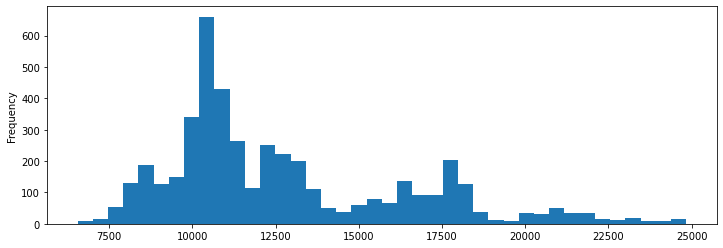

In [ ]:
y.plot.hist(bins=40, figsize=(12, 4))

In [ ]:
rois = []
for s in range(1000):
    np.random.seed(s)
    preds = np.random.normal(y_train.mean(), y_train.std(), len(y_val))
    rois.append(roi(y_val, preds))
print(np.mean(rois))

-0.43244292748307145


## Modelli

In [ ]:
models = {}

In [ ]:
## Calcola la loss solo sull'utlimo elemento del batch
class RNNMSELoss(MSELoss):
    def __call__(self, input, target):
        return super().__call__(input, target[-1])

NameError: ignored

In [ ]:
n_days= 10
lstm = NeuralNetRegressor(
    module=Sequence,
    optimizer=optim.Adam,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=210,
    
    
    module__nb_features=X.shape[1],
    module__hidden_size=256, 
    module__nb_layers=2,
    optimizer__lr=0.0005,
    optimizer__amsgrad=True
)

In [ ]:
ridge_regr = Pipeline([
    ("scale",  StandardScaler()),
    ("regr", Ridge())
])
ridge_regr_grid = {
    "regr__alpha": [0.1, 1, 10, 50]
}
models["ridge_regr"] = (ridge_regr, ridge_regr_grid)

In [ ]:
linear_regression = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", None),
    ("regr", LinearRegression())
])
lin_regr_grid = {
    "scale": [None, StandardScaler()],
    "poly__degree": list(range(1, 7))
}
models["lin_regr"] = (linear_regression, lin_regr_grid)

In [ ]:
kernel_ridge = Pipeline([
    ("scale", None),
    ("regr", KernelRidge(kernel="rbf"))
])
k_ridge_grid = {
    "scale": [None, StandardScaler()],
    "regr__gamma": [0.001, 0.01, 0.1],
    "regr__alpha": np.logspace(-3, 2, 6)
}
models["k_ridge"] = (kernel_ridge, k_ridge_grid)

## Grid Search per trovare gli iperparametri migliori

In [ ]:
tss = TimeSeriesSplit(3)
roi_scorer = make_scorer(roi, greater_is_better=True)
scoring = {
    "roi": roi_scorer
}

In [ ]:
results = {}
for model_name, model_data in models.items():
    model = model_data[0]
    grid = model_data[1]
    gs = GridSearchCV(model, grid, scoring=scoring, cv=tss, refit="roi")
    gs.fit(X, y)
    cv_results = pd.DataFrame(gs.cv_results_)
    results[model_name] = cv_results

In [ ]:
pd.set_option('display.max_columns', None)
for model_name in models.keys():
    print(f"-------------{model_name}--------------")
    display(results[model_name].sort_values("mean_test_roi", ascending=False).head(5))
    print("\n\n")
    #si puo' fare con un dataframe con indice gerarchico

-------------ridge_regr--------------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__alpha,params,split0_test_roi,split1_test_roi,split2_test_roi,mean_test_roi,std_test_roi,rank_test_roi
2,0.003494,0.000117,0.002162,0.000169,10,{'regr__alpha': 10},-0.029932,-0.001615,0.398462,0.122305,0.195614,1
3,0.003416,0.000258,0.002076,0.000074,50,{'regr__alpha': 50},0.061993,-0.024026,0.109699,0.049222,0.055335,2
1,0.003644,0.000448,0.002820,0.000367,1,{'regr__alpha': 1},-0.006495,0.030744,0.031438,0.018562,0.017721,3
0,0.003727,0.000400,0.002143,0.000023,0.1,{'regr__alpha': 0.1},-0.050108,-0.014879,0.049432,-0.005185,0.041211,4





-------------lin_regr--------------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_scale,params,split0_test_roi,split1_test_roi,split2_test_roi,mean_test_roi,std_test_roi,rank_test_roi
4,0.011034,0.001744,0.003804,0.000331,3,None,"{'poly__degree': 3, 'scale': None}",0.191562,-0.165067,0.687484,0.237993,0.349598,1
5,0.014915,0.002911,0.004506,0.000140,3,"StandardScaler(copy=True, with_mean=True, with...","{'poly__degree': 3, 'scale': StandardScaler(co...",0.191562,-0.165067,0.687484,0.237993,0.349598,1
10,0.315050,0.176616,0.006685,0.000038,6,None,"{'poly__degree': 6, 'scale': None}",0.342689,-0.159093,0.241984,0.141860,0.216741,3
6,0.029804,0.007330,0.004875,0.000170,4,None,"{'poly__degree': 4, 'scale': None}",0.125119,-0.010477,0.295892,0.136845,0.125349,4
7,0.032840,0.005772,0.007213,0.002876,4,"StandardScaler(copy=True, with_mean=True, with...","{'poly__degree': 4, 'scale': StandardScaler(co...",0.125119,-0.010477,0.295892,0.136845,0.125349,4





-------------k_ridge--------------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__alpha,param_regr__gamma,param_scale,params,split0_test_roi,split1_test_roi,split2_test_roi,mean_test_roi,std_test_roi,rank_test_roi
7,0.072577,0.050123,0.017760,0.005557,0.01,0.001,"StandardScaler(copy=True, with_mean=True, with...","{'regr__alpha': 0.01, 'regr__gamma': 0.001, 's...",-0.085762,0.400412,0.910933,0.408528,0.406940,1
8,0.071150,0.049809,0.019299,0.004225,0.01,0.01,None,"{'regr__alpha': 0.01, 'regr__gamma': 0.01, 'sc...",0.256125,0.397554,0.444282,0.365987,0.079992,2
1,0.086959,0.063666,0.017870,0.005306,0.001,0.001,"StandardScaler(copy=True, with_mean=True, with...","{'regr__alpha': 0.001, 'regr__gamma': 0.001, '...",-0.168346,0.469475,0.694707,0.331946,0.365514,3
14,0.071230,0.050763,0.017533,0.006215,0.1,0.01,None,"{'regr__alpha': 0.1, 'regr__gamma': 0.01, 'sca...",0.298136,0.277266,0.292547,0.289316,0.008821,4
21,0.076957,0.055982,0.018027,0.005427,1,0.01,"StandardScaler(copy=True, with_mean=True, with...","{'regr__alpha': 1.0, 'regr__gamma': 0.01, 'sca...",-0.018269,0.142085,0.711317,0.278377,0.313056,5


## Modello Migliore
Dall'analisi dei risultati di Grid Search, selezioniamo il modello nella cella seguente.

Questo modello ha un return of investment abbastanza alto(mean_test_roi) e 
che hanno una deviazione standard di questo errore(std_test_roi) bassa. 

Questo e' importante poiche' vuol dire che l'accuratezza delle predizioni fatte da queti modelli non varia
significativamente cambiando i dati, e questo le rende affidabili.

Nell'analisi precedente, vi sono infatti modelli con ROI piu' alto di questo, ma con una deviazione standard motlo alta, e cio' fa si che siano inaffidabili.

In [ ]:
#kernel ridge ha il roi migliore e ha una deviazione standard sui fold set motlo bassa
best = Pipeline([
    ("scale", None),
    ("regr", KernelRidge(kernel="rbf", alpha=0.1, gamma=0.01))
])

## Interpretazione dei coefficienti del modello migliore
Dall'analisi dei coefficienti dei parametri riportata di seguito, si nota che la maggiorparte di questi e' negativa e cio' vuol dire che i parametri scelti sono inversamente proporzionali alla variabile da predire, delta.

Come parametri abbiamo usato le differenze tra valore del delta/prezzo e media del delta/prezzo.

Il fatto che i coefficienti di questi parametri siano negativi indica che, visto che il prezzo, nel lasso di pochi gionri (in questo caso 3) rimane circa intorno al suo valore medio, se nei giorni precedenti ha assunto valori sotto quello medio, e' probabile che il giorno attuale risalga e che quindi a fine giornata il pezzo sia piu' alto rispetto a quello di inizio giornata.

In [ ]:
best.fit(X, y)
coef = pd.Series(np.dot(X.transpose(),best["regr"].dual_coef_), X.columns)
coef.sort_values(ascending=False)

DeltaVsSMALag3     3545.059666
DeltaVsSMALag2   -12340.342246
DeltaVsSMALag1   -15778.464910
PriceVsSMALag2   -49600.965146
PriceVsSMALag1   -50322.669523
PriceVsSMALag3   -56478.079805
dtype: float64